# Predicting Industrial Machine Downtime

## 📖 Background
You work for a manufacturer of high-precision metal components used in aerospace, automotives, and medical device applications. Your company operates three different machines on its shop floor that produce different sized components, so minimizing the downtime of these machines is vital for meeting production deadlines.

Your team wants to use a data-driven approach to predicting machine downtime, so proactive maintenance can be planned rather than being reactive to machine failure. To support this, your company has been collecting operational data for over a year and whether each machine was down at those times.

In this first level, you're going to explore and describe the data. This level is aimed towards beginners. If you want to challenge yourself a bit more, check out level two!

## 💾 The data

The company has stored the machine operating data in a single table, available in `'data/machine_downtime.csv'`.

#### Each row in the table represents the operational data for a single machine on a given day:
- `"Date"` - the date the reading was taken on.
- `"Machine_ID"` - the unique identifier of the machine being read.
- `"Assembly_Line_No"` - the unique identifier of the assembly line the machine is located on.
- `"Hydraulic_Pressure(bar)"`, `"Coolant_Pressure(bar)"`, and `"Air_System_Pressure(bar)"` - pressure measurements at different points in the machine.
- `"Coolant_Temperature"`, `"Hydraulic_Oil_Temperature"`, and `"Spindle_Bearing_Temperature"` - temperature measurements (in Celsius) at different points in the machine.
- `"Spindle_Vibration"`, `"Tool_Vibration"`, and `"Spindle_Speed(RPM)"` - vibration (measured in micrometers) and rotational speed measurements for the spindle and tool.
- `"Voltage(volts)"` - the voltage supplied to the machine.
- `"Torque(Nm)"` - the torque being generated by the machine.
- `"Cutting(KN)"` - the cutting force of the tool.
- `"Downtime"` - an indicator of whether the machine was down or not on the given day.

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import KNNImputer
import math
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Data Analysis

In [2]:
# read the data and print the first few rows
machine_downtime = pd.read_csv('C://Users/Administrator/Documents/Data Science Projects/Machine-Downtime-Prediction/data/machine_downtime.csv')
machine_downtime.head()

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,71.04,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,Machine_Failure
1,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,125.33,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,Machine_Failure
2,31-12-2021,Makino-L3-Unit1-2015,Shopfloor-L3,71.12,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,Machine_Failure
3,31-05-2022,Makino-L2-Unit1-2015,Shopfloor-L2,139.34,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,Machine_Failure
4,31-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,60.51,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,Machine_Failure


#### Useful Functions

In [4]:
def plot_numeric_features(df, plot_type="boxplot", cols=4, figsize_multiplier=4):
    """
    Plots numerical columns from a dataframe in a grid layout.

    Parameters:
    df (pd.DataFrame): The dataframe containing numerical columns.
    plot_type (str): Type of plot to generate ("boxplot", "histogram", or "violin").
    cols (int): Number of columns in the grid.
    figsize_multiplier (int): Multiplier to adjust figure size dynamically.

    Returns:
    None: Displays the generated plots.
    """
    # Select only numerical columns
    feature_numeric = df.select_dtypes(include=['number'])

    # Determine grid size
    num_cols = feature_numeric.shape[1]
    rows = math.ceil(num_cols / cols)  # Compute required rows dynamically

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, figsize_multiplier * rows))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Iterate over each numerical column and plot
    for i, col in enumerate(feature_numeric.columns):
        if plot_type == "boxplot":
            sns.boxplot(y=feature_numeric[col], ax=axes[i])
        elif plot_type == "histogram":
            sns.histplot(feature_numeric[col], ax=axes[i], kde=True, bins=30)
        elif plot_type == "violin":
            sns.violinplot(y=feature_numeric[col], ax=axes[i])
        else:
            raise ValueError("Invalid plot type. Choose 'boxplot', 'histogram', or 'violin'.")

        axes[i].set_title(col)

    # Remove any empty subplots
    for i in range(num_cols, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## Data Wrangling

In [5]:
# create a copy of the original data
machine_downtime_ori = machine_downtime.copy()

### 1. inconsistent data types and NaN values 
+ The `Date` column is type **object** instead of type **datetime**, We will also convert the `Assembly_Line_No` and `Downtime` from **Object** to **Category** typr
+ There are NaN values in majority of the columns. we need to do further analysis on that
+ The other column data types are okay


In [6]:
# get data types of columns
machine_downtime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         2500 non-null   object 
 1   Machine_ID                   2500 non-null   object 
 2   Assembly_Line_No             2500 non-null   object 
 3   Hydraulic_Pressure(bar)      2490 non-null   float64
 4   Coolant_Pressure(bar)        2481 non-null   float64
 5   Air_System_Pressure(bar)     2483 non-null   float64
 6   Coolant_Temperature          2488 non-null   float64
 7   Hydraulic_Oil_Temperature    2484 non-null   float64
 8   Spindle_Bearing_Temperature  2493 non-null   float64
 9   Spindle_Vibration            2489 non-null   float64
 10  Tool_Vibration               2489 non-null   float64
 11  Spindle_Speed(RPM)           2494 non-null   float64
 12  Voltage(volts)               2494 non-null   float64
 13  Torque(Nm)        

Looking at the plot below, there is no pattern to the missing values as they seem to be generally random.

### 2. Value range constraint 
+ There are negative values in `Hydraulic_pressure` and `Spindle_Vibration` column. we will investigate that
+ We would convert the `cutting(kN)` SI unit column to **newton(N)** from **KiloNewton(kN)** and the `Spindle_Speed` from **Rotation per minute (RPM)** to **Rotation per seconds(RPS)** since all other variable are in their standard units
+ for the `Date` column, we will drill into it more during the data correction phase
+ `Coolant temperature` of 4C seems unusual. we will investigate later and also a pretty high teprature of 98C seems unusual too
+ The `tool vibration` column also has a minimum value of 2.16 which when when compared with others seems impossible to be.
+ we aso have a minimum value for `spindle speed` and `Torque` to be zero. This is possible only of the machine is not operating at that moment or a fault in the sensor





In [7]:
# get the summray statistics of the data
machine_downtime_ori.describe()

,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN)
count,2490.000000,2481.000000,2483.000000,2488.000000,2484.000000,2493.000000,2489.000000,2489.000000,2494.000000,2494.000000,2479.000000,2493.000000
mean,101.409084,4.947058,6.499275,18.559887,47.618317,35.063698,1.009334,25.411975,20274.792302,348.996792,25.234968,2.782551
std,30.289301,0.997357,0.407279,8.554480,3.768674,3.764823,0.342898,6.437142,3852.660056,45.376024,6.138564,0.616688
min,-14.326454,0.325000,5.063480,4.100000,35.200000,22.600000,-0.461000,2.161000,0.000000,202.000000,0.000000,1.800000
25%,76.355000,4.462464,6.217987,10.400000,45.100000,32.500000,0.777000,21.089000,17919.000000,319.000000,21.666115,2.250000
50%,96.763486,4.939960,6.505191,21.200000,47.700000,35.100000,1.008000,25.455000,20137.500000,349.000000,24.647736,2.780000
75%,126.415727,5.518401,6.780550,25.600000,50.100000,37.600000,1.236000,29.790000,22501.750000,380.000000,30.514008,3.270000
max,191.000000,11.350000,7.973992,98.200000,61.400000,49.500000,2.000000,45.726000,27957.000000,479.000000,55.552400,3.930000


#### 2.1 Detecting Outliers in The Data
From the boxplots in the image, here are some key inferences about the numerical data:

1. Presence of Outliers
> + Several columns show a significant number of outliers, which are represented as dots outside the whiskers.
> + High number of outliers:
Voltage(volts), Torque(Nm), Air_System_Pressure(Pa), Tool_Vibration, and Coolant_Pressure(Pa)
These variables have extreme values that could indicate measurement anomalies, rare events, or genuine variations in the data.
2. Distribution Insights
> + Most of the boxplots show a relatively symmetric distribution, but some have skewness:
>  + Positively Skewed (Right-tailed): Hydraulic_Oil_Temperature, Voltage(volts), Cutting(N)
Negatively Skewed (Left-tailed): Spindle_Speed(RPS) (due to a low extreme outlier)
3. Spread of Data (Variability)
> + Columns with High Spread:
Hydraulic_Pressure(Pa), Voltage(volts), and Cutting(N) have a large range of values.
This could suggest that these parameters vary significantly in the dataset.
> + Columns with Low Spread:
Spindle_Vibration and Spindle_Bearing_Temperature have a smaller range, meaning the values are more consistent.
4. Potential Data Quality Issues
> + Some extreme outliers might be due to sensor errors, faulty readings, or noise in the dataset.
> + Others might be a normal range of values for the specific feature in question

If these outliers are not expected in the domain (e.g., industrial sensors in automation and robotics), it might be worth investigating their source.

In our data cleaning phase, only the extreme maximum amd extreme minimum will be removed from the record and this will be for specific columns like `Coolant_Pressure`, `Coolant_temperature`, `Spindle_Speed`, `Torque`.

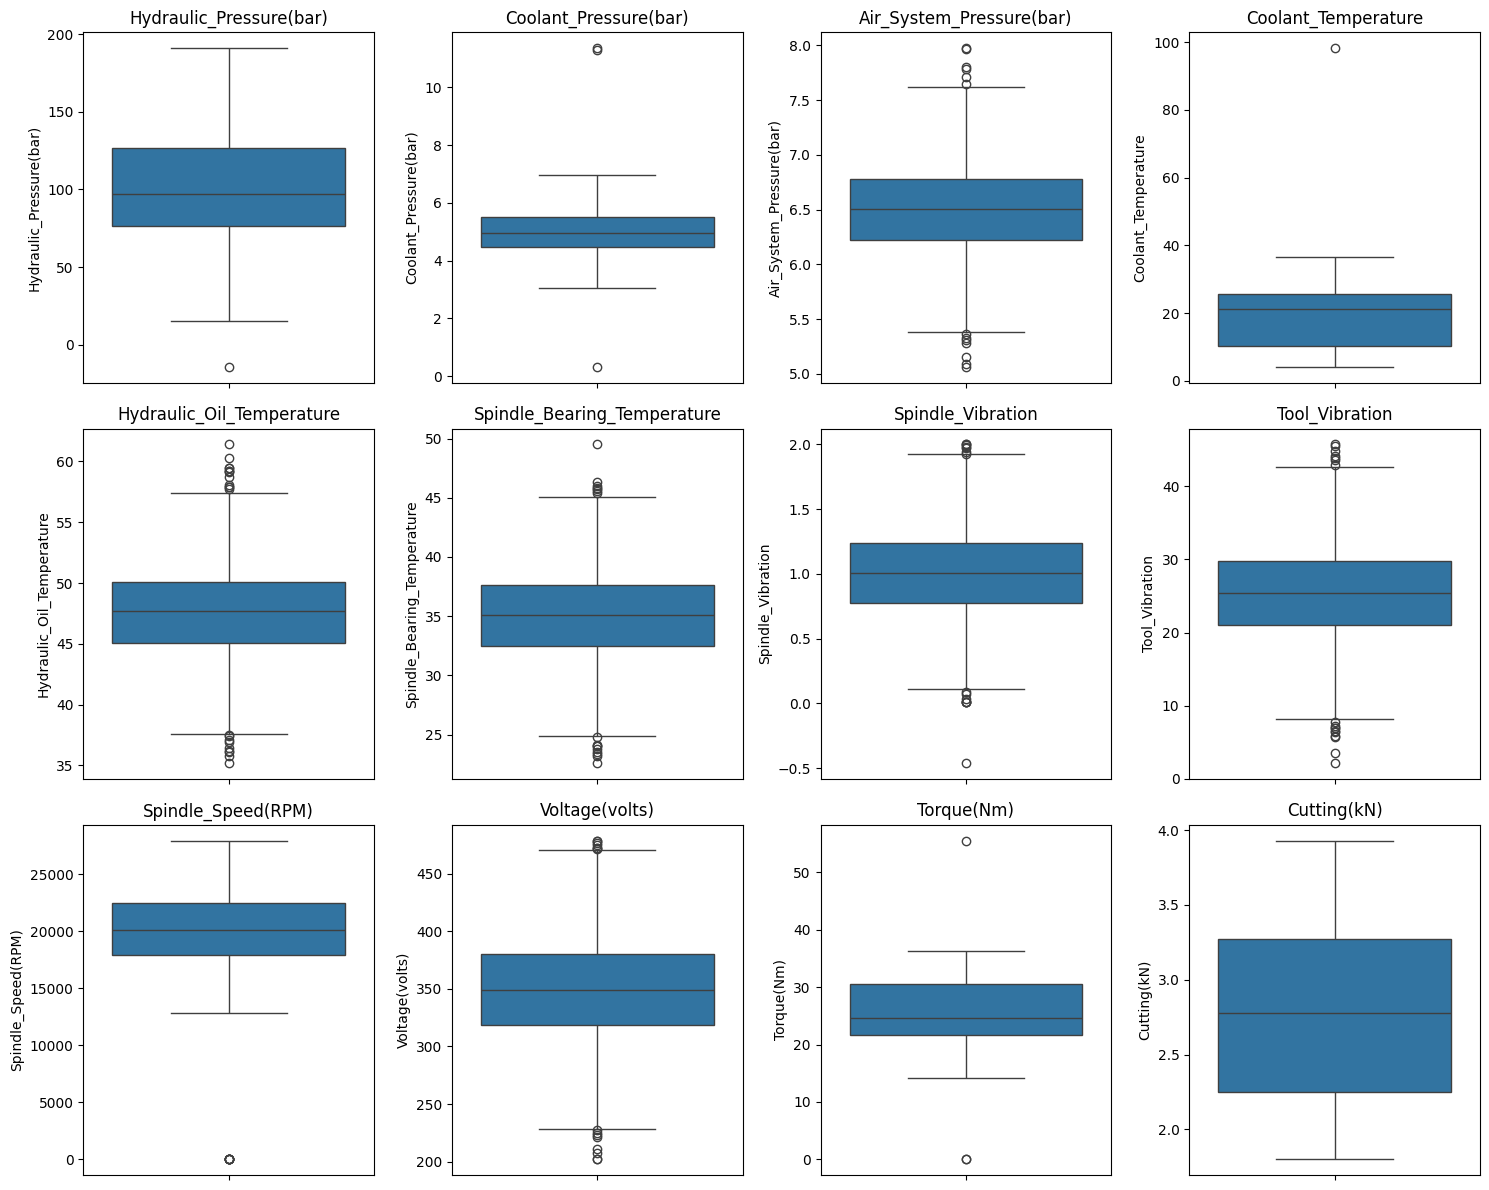

In [9]:
plot_numeric_features(machine_downtime_ori, plot_type='boxplot')

### 3. Uniqueness Constraints
+ No spelling irregularities in the `Downtime` column
+ There are no duplicates present


In [33]:
# check the values of `downtime` column
machine_downtime_ori.Downtime.unique()

array(['Machine_Failure', 'No_Machine_Failure'], dtype=object)

In [34]:
# check for duplicates
duplicate_records = machine_downtime_ori.duplicated().sum()
print(f"the number of duplicate is {duplicate_records}")

the number of duplicate is 0


## Data Cleaning
We will be cleaning our data after performing some initial exploration. 

### 1.1 Change `Date` column to `datatime` type

+ We will convert the Date column data type from object type to datetime
+ There seems to be disparity in the arrangement of the records as they are not arranged in the right order. I will sort the dataframe by date column in ascending order. 


In [35]:
# change the date column to datetime
machine_downtime_ori['Date'] = pd.to_datetime(machine_downtime_ori['Date'],
                                              errors='coerce')
# verify 
machine_downtime_ori.Date.dtype

dtype('<M8[ns]')

Looking at the first few rows, the row with the min date value does not correspond to the first row and the same can be seen for the last row as it does not correspond the record with the max date value. we will address this

In [36]:
machine_downtime_ori.head()

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,2021-12-31,Makino-L1-Unit1-2013,Shopfloor-L1,71.04,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,Machine_Failure
1,2021-12-31,Makino-L1-Unit1-2013,Shopfloor-L1,125.33,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,Machine_Failure
2,2021-12-31,Makino-L3-Unit1-2015,Shopfloor-L3,71.12,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,Machine_Failure
3,2022-05-31,Makino-L2-Unit1-2015,Shopfloor-L2,139.34,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,Machine_Failure
4,2022-03-31,Makino-L1-Unit1-2013,Shopfloor-L1,60.51,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,Machine_Failure


In [37]:
machine_downtime_ori.tail()

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
2495,2022-02-01,Makino-L1-Unit1-2013,Shopfloor-L1,112.715506,5.220885,6.196610,22.3,48.8,37.2,0.910,20.282,20974.0,282.0,22.761610,2.72,No_Machine_Failure
2496,2022-02-01,Makino-L1-Unit1-2013,Shopfloor-L1,103.086653,5.211886,7.074653,11.9,48.3,31.5,1.106,34.708,20951.0,319.0,22.786597,2.94,No_Machine_Failure
2497,2022-02-01,Makino-L2-Unit1-2015,Shopfloor-L2,118.643165,5.212991,6.530049,4.5,49.9,36.2,0.288,16.828,20958.0,335.0,22.778987,NaN,No_Machine_Failure
2498,2022-02-01,Makino-L3-Unit1-2015,Shopfloor-L3,145.855859,5.207777,6.402655,12.2,44.5,32.1,0.995,26.498,20935.0,376.0,22.804012,2.79,No_Machine_Failure
2499,2022-02-01,Makino-L2-Unit1-2015,Shopfloor-L2,96.690000,5.936610,7.109355,29.8,53.2,36.2,0.840,31.580,23576.0,385.0,24.409551,3.55,Machine_Failure


In [38]:
# get the max date value
machine_downtime_ori.Date.max()

Timestamp('2022-07-03 00:00:00')

In [39]:
# get the min date value
machine_downtime_ori.Date.min()

Timestamp('2021-11-24 00:00:00')

In [40]:
# rearrange the dataframe based on the date column
machine_downtime_ori = machine_downtime_ori.sort_values(by = 'Date', ignore_index= True)
machine_downtime_ori.head()     # print the first few row to verify this

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,2021-11-24,Makino-L3-Unit1-2015,Shopfloor-L3,88.640000,6.560332,6.210167,6.1,44.4,36.8,0.815,24.067,0.0,328.0,29.005529,2.26,Machine_Failure
1,2021-12-08,Makino-L2-Unit1-2015,Shopfloor-L2,141.159193,5.138601,6.127650,4.5,47.9,31.2,1.225,35.214,15217.0,381.0,23.091903,2.87,No_Machine_Failure
2,2021-12-17,Makino-L2-Unit1-2015,Shopfloor-L2,72.466020,5.141113,6.629322,21.7,47.5,35.8,1.078,29.198,17726.0,367.0,31.620335,2.97,No_Machine_Failure
3,2021-12-17,Makino-L1-Unit1-2013,Shopfloor-L1,88.280000,6.839413,6.560381,5.2,49.4,34.2,1.266,30.206,27957.0,340.0,15.900716,2.70,Machine_Failure
4,2021-12-17,Makino-L1-Unit1-2013,Shopfloor-L1,74.540000,6.580195,6.528837,24.4,48.1,36.6,0.778,25.048,27957.0,307.0,23.923929,3.59,Machine_Failure


We also have to convert the `Machine_ID`, `Downtime` and `Assembly_Line_No` from Object data type to categorical

In [41]:
# connvert the columns of object type to Category type
object_column = machine_downtime_ori.select_dtypes(include='object').columns
machine_downtime_ori[object_column] = machine_downtime_ori[object_column].astype('category')

# verufy 
machine_downtime_ori[object_column].dtypes

Machine_ID          category
Assembly_Line_No    category
Downtime            category
dtype: object

### 1.2 Imputing Missing Values

We will drill down on the NaN values to determine whether to impute or drop the NaN values
 

Looking at the diagram below, which presents the missing values in a graphical format using the missingno library, I observed that there is no clear pattern to the missing values, as they appear randomly. However, I noticed a particular section in the data where the `torque` and `voltage` columns contain NaN values. This could be due to sensor failure, system downtime, or specific operating conditions where no readings were recorded. Similarly, the `coolant pressure` and `column temperature` columns exhibit the same behavior, suggesting potential sensor-related issues or machine inactivity during those periods.

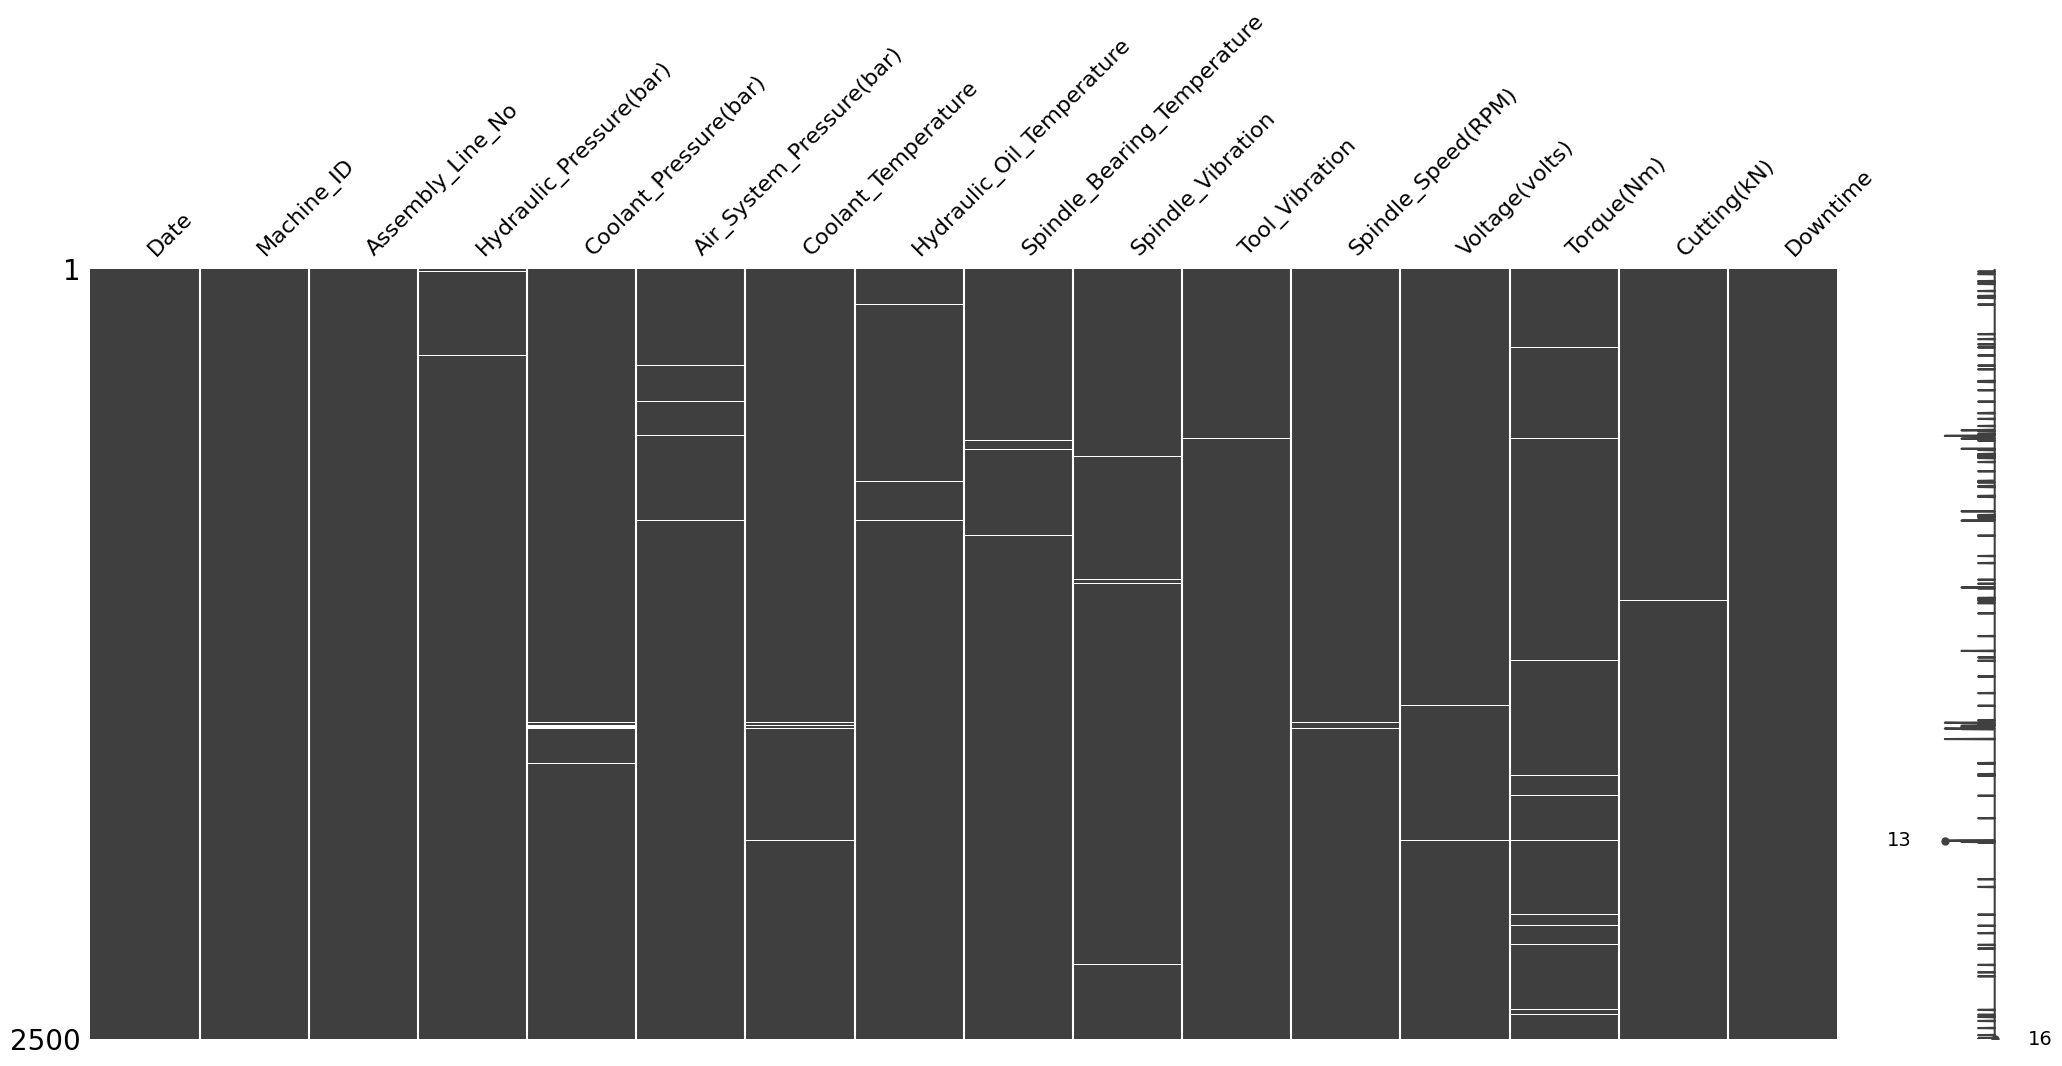

In [42]:
# plot the missing value matrix 
msno.matrix(machine_downtime_ori)
plt.show()

Let us try to plot the distribution of the numerical column to see the underlying patter in order to use the appropriate imputation method
from the distibution plots below, we can see that some features exhibit normal distribution while others were either right-skewed or left-skewed.We will be using an advanced method of imputation - The KNN imputation to fill in our missing values in each column

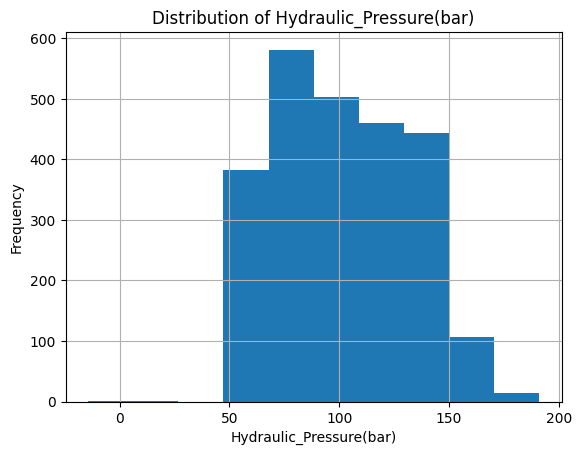

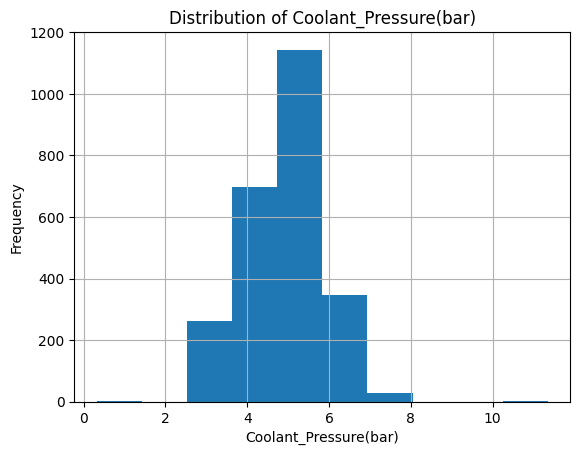

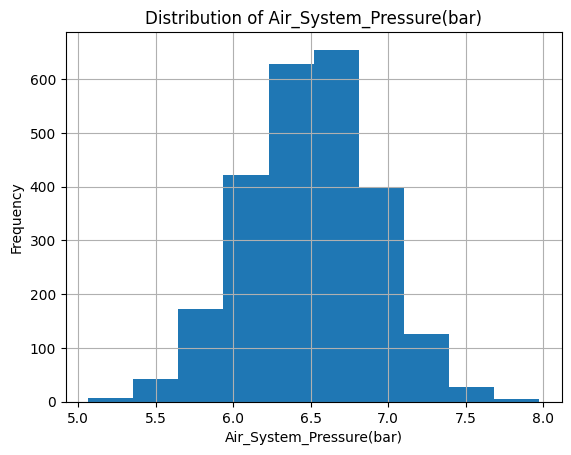

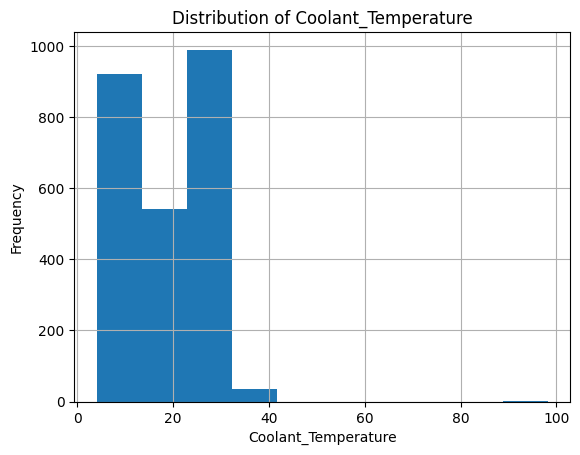

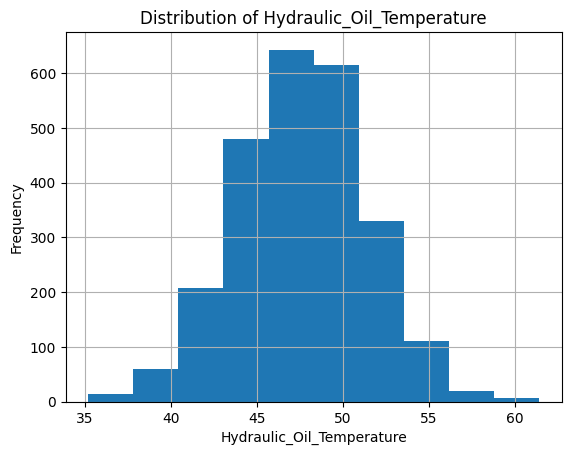

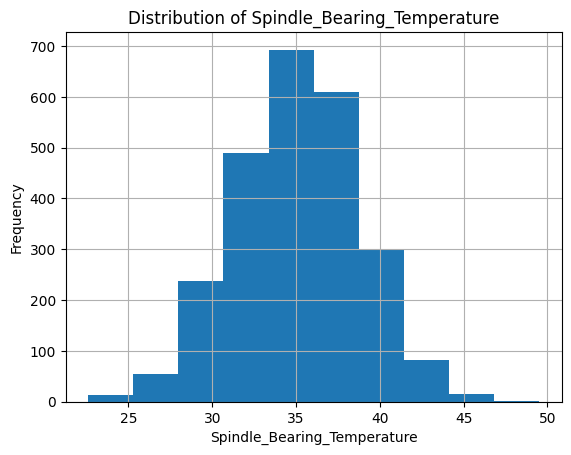

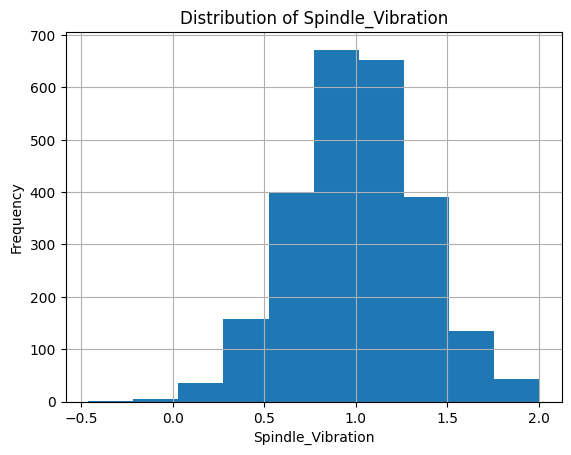

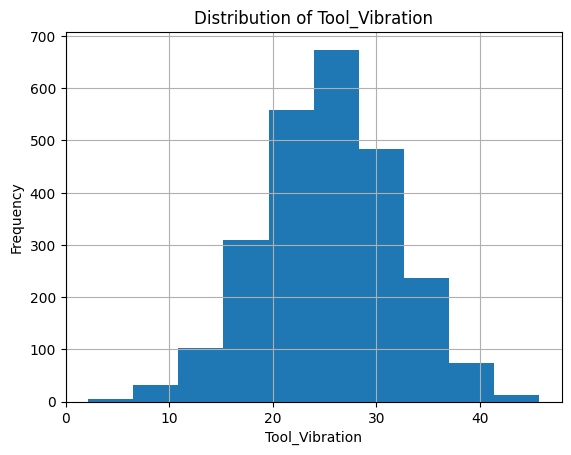

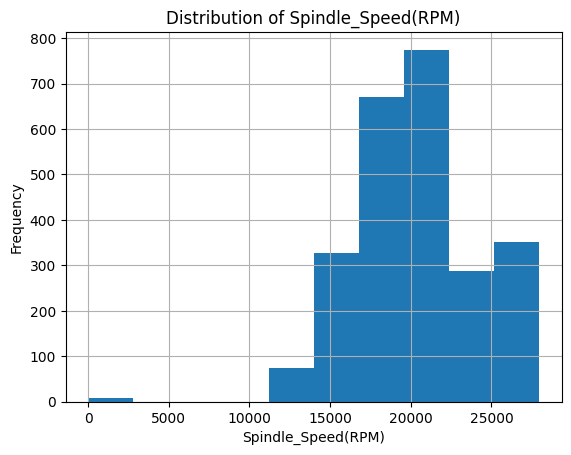

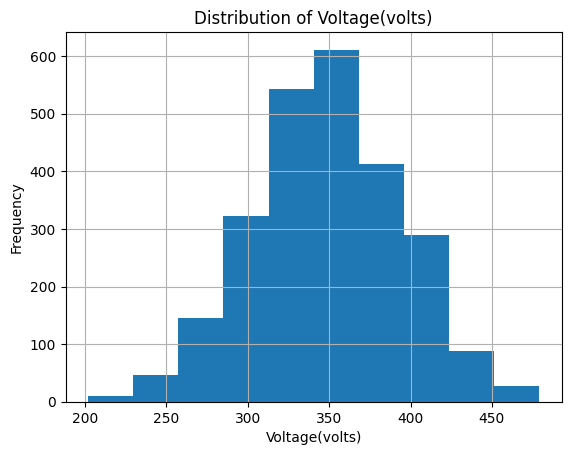

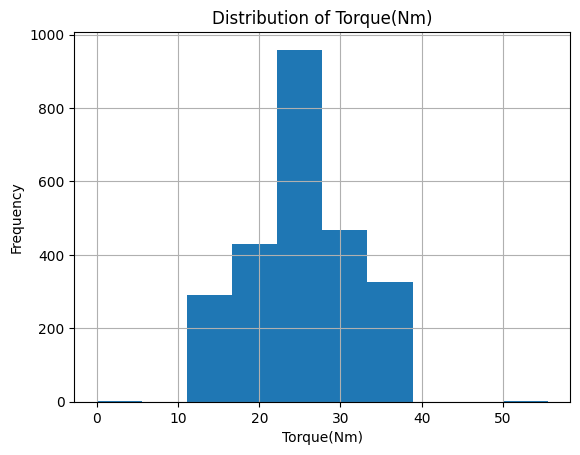

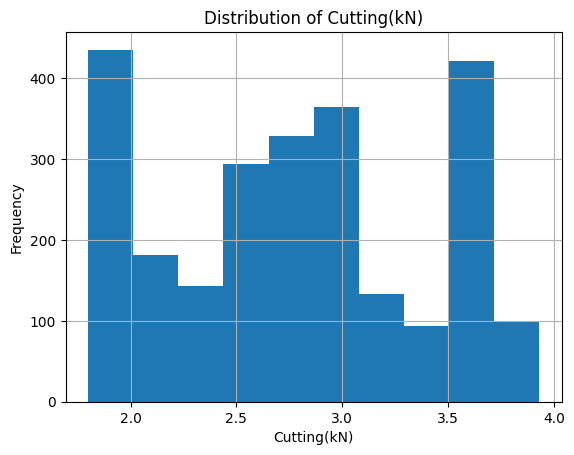

In [43]:
# create a list for all the numerical columns with NaN
numerical_cols_with_nan = machine_downtime_ori.select_dtypes(include=np.number)\
                          .columns[machine_downtime_ori.select_dtypes(include=np.number).isnull().any()].tolist()

for col in numerical_cols_with_nan:
    plt.figure()  # Create a new figure for each plot
    machine_downtime_ori[col].hist() # or df[col].plot.hist()
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
  

KNN imputation will be used to address missing values across the dataset, leveraging inter-variable relationships to estimate missing data points and ensure a complete dataset for analysis. KNN imputation estimates missing values by considering the values of similar data points, thereby ensuring a complete and consistent dataset for analysis.

In [44]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3) # initialize the imputer
machine_downtime_ori[numerical_cols_with_nan] = imputer.fit_transform(machine_downtime_ori[numerical_cols_with_nan]) # Impute based on both columns

# verify that there is no more missing values
machine_downtime_ori.isna().sum()

Date                           0
Machine_ID                     0
Assembly_Line_No               0
Hydraulic_Pressure(bar)        0
Coolant_Pressure(bar)          0
Air_System_Pressure(bar)       0
Coolant_Temperature            0
Hydraulic_Oil_Temperature      0
Spindle_Bearing_Temperature    0
Spindle_Vibration              0
Tool_Vibration                 0
Spindle_Speed(RPM)             0
Voltage(volts)                 0
Torque(Nm)                     0
Cutting(kN)                    0
Downtime                       0
dtype: int64

#### 1.3 Convert Columns values to its S.I unit values

+ We will convert the `Cutting (kN)` column from kN to Newton
+ we will also round off the values of each numerical to have conistency in the decimal place.
+ WE will convert the `Spindle Speed` from RPM to RPS 
+ convert the pressure columns from bar to Pa




In [45]:
import re  # Import the regular expression module

def convert_units(df):
    """Converts pressure from bar to Pa, force from kN to N, and spindle speed from RPM to RPS,
       rounding the results to 1 decimal place. Handles multiple pressure columns 
       containing "pressure" and "(bar)".

    Args:
        df: The Pandas DataFrame containing the data.

    Returns:
        A new Pandas DataFrame with converted units, rounded to 1 decimal place.
        Returns the original DataFrame if no conversion is needed.
    """

    # Pressure (bar to Pa) - Handles multiple pressure columns containing "Pressure" and "(bar)"
    for col in df.columns:
        if "Pressure" in col and "(bar)" in col:
            new_col_name = re.sub(r"\(bar\)", "(Pa)", col) # Use regex to replace (bar) with (Pa)
            df[new_col_name] = (df[col].astype(float) * 100000).round(1) #convert to float before multiplication
            df = df.drop(columns=[col])

    # Force (kN to N)
    if 'Cutting(kN)' in df.columns:
        df['Cutting(N)'] = (df['Cutting(kN)'] * 1000).round(1)
        df = df.drop(columns=['Cutting(kN)'])

    # Spindle Speed (RPM to RPS)
    if 'Spindle_Speed(RPM)' in df.columns:
        df['Spindle_Speed(RPS)'] = (df['Spindle_Speed(RPM)'] / 60).round(1)
        df= df.drop(columns=['Spindle_Speed(RPM)'])

    return df

# apply the function to the dataframe
machine_downtime_ori = convert_units(machine_downtime_ori)
machine_downtime_ori.head()

,Date,Machine_ID,Assembly_Line_No,Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Voltage(volts),Torque(Nm),Downtime,Hydraulic_Pressure(Pa),Coolant_Pressure(Pa),Air_System_Pressure(Pa),Cutting(N),Spindle_Speed(RPS)
0,2021-11-24,Makino-L3-Unit1-2015,Shopfloor-L3,6.1,44.4,36.8,0.815,24.067,328.0,29.005529,Machine_Failure,8864000.0,656033.2,621016.7,2260.0,0.0
1,2021-12-08,Makino-L2-Unit1-2015,Shopfloor-L2,4.5,47.9,31.2,1.225,35.214,381.0,23.091903,No_Machine_Failure,14115919.3,513860.1,612765.0,2870.0,253.6
2,2021-12-17,Makino-L2-Unit1-2015,Shopfloor-L2,21.7,47.5,35.8,1.078,29.198,367.0,31.620335,No_Machine_Failure,7246602.0,514111.3,662932.2,2970.0,295.4
3,2021-12-17,Makino-L1-Unit1-2013,Shopfloor-L1,5.2,49.4,34.2,1.266,30.206,340.0,15.900716,Machine_Failure,8828000.0,683941.3,656038.1,2700.0,466.0
4,2021-12-17,Makino-L1-Unit1-2013,Shopfloor-L1,24.4,48.1,36.6,0.778,25.048,307.0,23.923929,Machine_Failure,7454000.0,658019.5,652883.7,3590.0,466.0


#### 1.4 Negative values in Hydraulic pressure column and Spindle vibration column
During my analysis, I encountered negative values in my sensor data, but they appear in different rows for hydraulic pressure and spindle vibration. I have one row with a negative hydraulic pressure reading. Negative hydraulic pressure in our system is highly improbable, suggesting a sensor or data acquisition error.

Separately, I have another row with negative spindle vibration value.  These negative values, while valid in the context of vibration, is quite small (less than 0.5). Unlike the pressure readings, negative values for spindle vibration are perfectly normal.  Vibration is an oscillatory motion, meaning the spindle moves back and forth.  A negative vibration value simply indicates the direction of movement – in this case, towards the sensor

Given that it's only one row for each feature, I'm inclined to believe it's an isolated incident and not representative of the overall system behavior.  I've decided to remove this single row for each column from my dataset.  Since it's just one data point, removing it shouldn't significantly impact my overall analysis, and it will prevent this erroneous data from skewing any calculations or models I might build


In [46]:
# check the number of rows where the hydraulic pressure is negative
hydraulic_neg = machine_downtime_ori[machine_downtime_ori['Hydraulic_Pressure(Pa)'] <= 0]
hydraulic_neg

,Date,Machine_ID,Assembly_Line_No,Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Voltage(volts),Torque(Nm),Downtime,Hydraulic_Pressure(Pa),Coolant_Pressure(Pa),Air_System_Pressure(Pa),Cutting(N),Spindle_Speed(RPS)
287,2022-02-06,Makino-L3-Unit1-2015,Shopfloor-L3,6.8,49.6,39.2,1.627,17.723,348.0,33.923365,No_Machine_Failure,-1432645.4,506726.1,616399.9,2730.0,339.8


In [47]:
# check the number of rows where the Spindle Vibration is negative
spindle_neg = machine_downtime_ori[machine_downtime_ori['Spindle_Vibration'] <= 0]
spindle_neg

,Date,Machine_ID,Assembly_Line_No,Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Voltage(volts),Torque(Nm),Downtime,Hydraulic_Pressure(Pa),Coolant_Pressure(Pa),Air_System_Pressure(Pa),Cutting(N),Spindle_Speed(RPS)
792,2022-02-28,Makino-L2-Unit1-2015,Shopfloor-L2,8.7,51.1,35.9,-0.461,16.647,349.0,21.533694,No_Machine_Failure,12202879.1,553740.1,579985.0,2850.0,320.0


In [48]:
# drop the rows with negative value
machine_downtime_ori = machine_downtime_ori.drop(machine_downtime_ori[(machine_downtime_ori['Hydraulic_Pressure(Pa)'] < 0)\
                       | ((machine_downtime_ori['Spindle_Vibration'] < 0))].index)

# check for verification
machine_downtime_ori[(machine_downtime_ori['Hydraulic_Pressure(Pa)'] < 0)\
                       | ((machine_downtime_ori['Spindle_Vibration'] < 0))]

,Date,Machine_ID,Assembly_Line_No,Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Voltage(volts),Torque(Nm),Downtime,Hydraulic_Pressure(Pa),Coolant_Pressure(Pa),Air_System_Pressure(Pa),Cutting(N),Spindle_Speed(RPS)


#### Removing Extreme Outliers
Since most of the columns follow a normal distribution, but some are skewed, you can apply different outlier detection methods per column type:

+ we will Use Z-score (±3σ Rule) for Normally Distributed Columns
+ we use Use IQR (3 × IQR Rule) for Skewed Columns

In our data cleaning phase, only the extreme maximum amd extreme minimum will be removed from the record and this will be for specific columns like `Coolant_Pressure(Pa)`, `Coolant_temperature`, `Spindle_Speed(RPS)`, `Torque(Nm)`.

1. Identify Normal vs. Skewed Columns
> + First, determine which columns are normally distributed and which are skewed:

2. Remove Outliers by Method
> + Now, apply Z-score for normal columns and IQR for skewed columns:

In [49]:
# Function to classify columns
def classify_columns(df):
    
    """
    Classifies numerical columns into normal or skewed distributions based on the Shapiro-Wilk test.
    
    Parameters:
    df (pd.DataFrame): The input dataframe containing numerical data.
    
    Returns:
    tuple: A tuple containing:
        - normal_cols (list): List of column names that follow a normal distribution.
        - skewed_cols (list): List of column names that are skewed.
    """
    normal_cols = []
    skewed_cols = []
    
    for col in df.select_dtypes(include=['number']).columns:
        stat, p_value = stats.shapiro(df[col].dropna())  # Shapiro-Wilk test for normality
        if p_value > 0.05:  # p-value > 0.05 means normal distribution
            normal_cols.append(col)
        else:
            skewed_cols.append(col)
    
    return normal_cols, skewed_cols

# Get normal and skewed columns
normal_cols, skewed_cols = classify_columns(machine_downtime_ori)
print("Normal Distribution:", normal_cols)
print("Skewed Distribution:", skewed_cols)

Normal Distribution: ['Hydraulic_Oil_Temperature', 'Spindle_Bearing_Temperature', 'Spindle_Vibration', 'Tool_Vibration', 'Voltage(volts)', 'Air_System_Pressure(Pa)']
Skewed Distribution: ['Coolant_Temperature', 'Torque(Nm)', 'Hydraulic_Pressure(Pa)', 'Coolant_Pressure(Pa)', 'Cutting(N)', 'Spindle_Speed(RPS)']


In [50]:
def remove_outliers(df, columns_to_clean):
    """
    Removes extreme outliers only for specific numeric columns using:
    - Z-score (±3 standard deviations) for normally distributed columns.
    - IQR (Interquartile Range with 3 × IQR Rule) for skewed columns.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    columns_to_clean (list): List of specific column names where outlier removal should be applied.
    
    Returns:
    pd.DataFrame: A cleaned dataframe with extreme outliers removed only from the specified columns.
    """

    for col in columns_to_clean:
        # Check if column exists
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in dataframe.")
            continue
        
        # Detect normality of the column
        stat, p_value = stats.shapiro(df[col].dropna())  
        is_normal = p_value > 0.05  # If p > 0.05, assume normal distribution

        if is_normal:
            # Apply Z-score for normal distributions (±3σ Rule)
            z_scores = np.abs(stats.zscore(df[col]))
            df = df[z_scores < 3]  # Keep values within ±3σ
        else:
            # Apply IQR for skewed distributions (3 × IQR Rule)
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    df.reset_index(drop=True, inplace=True)
    return df


In [51]:
# get the list of the classified features
normal_cols, skewed_cols = classify_columns(machine_downtime_ori)  # Identify distributions

# specify columns to remove outliers from
columns_remove_outliers = ['Coolant_Pressure(Pa)', 'Coolant_Temperature', 'Spindle_Speed(RPS)', 'Torque(Nm)']
machine_downtime_ori = remove_outliers(machine_downtime_ori, columns_remove_outliers)  # Remove extreme outliers

print(f"New dataset size after removing extreme outliers: {machine_downtime_ori.shape}")

New dataset size after removing extreme outliers: (2487, 16)


#### Save The cleaned Data

In [52]:
# saved the cleaned data to a csv file
machine_downtime_ori.to_csv('C://Users/Administrator/Documents/Data Science Projects/Machine-Downtime-Prediction/data/machine_downtime_cleaned.csv', 
                            index=False)